In [139]:
import pandas as pd
import numpy as np
import scipy.stats as st
from datetime import datetime, timedelta, date
import pytz
from yahoo_fin import stock_info as si
from yahoo_fin import news
import ssl
import requests
from abc import ABC, abstractmethod
ssl._create_default_https_context = ssl._create_unverified_context
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 10)
sns.set()
# http://theautomatic.net/yahoo_fin-documentation/#get_quote_data
# https://www.bitstamp.net/api/#ticker
# https://medium.com/coinmonks/sourcing-intra-day-crypto-data-c804ea199baf
# https://www.cryptodatadownload.com/data/bitstamp/

In [140]:
si.get_top_crypto().head(10)

,Symbol,Name,Price (Intraday),Change,% Change,Market Cap,Volume in Currency (Since 0:00 UTC),Volume in Currency (24Hr),Total Volume All Currencies (24Hr),Circulating Supply
0,BTC-USD,Bitcoin USD,43085.680000,131.910000,0.31,8.156420e+11,1.831600e+10,1.831600e+10,1.831600e+10,18931000.0
1,ETH-USD,Ethereum USD,3322.000000,14.490000,0.44,3.959110e+11,9.344000e+09,9.344000e+09,9.344000e+09,119178000.0
2,BNB-USD,Binance Coin USD,492.280000,4.440000,0.91,8.211200e+10,1.712000e+09,1.712000e+09,1.712000e+09,166801000.0
3,USDT-USD,Tether USD,1.000700,-0.000000,-0.00,7.845800e+10,4.142500e+10,4.142500e+10,4.142500e+10,78400000000.0
4,SOL-USD,Solana USD,147.380000,1.830000,1.26,4.627900e+10,1.049000e+09,1.049000e+09,1.049000e+09,314010000.0
5,ADA-USD,Cardano USD,1.354100,0.089900,7.11,4.539900e+10,1.272000e+09,1.272000e+09,1.272000e+09,33527000000.0
6,USDC-USD,USD Coin USD,1.000100,0.000400,0.04,4.533200e+10,2.752000e+09,2.752000e+09,2.752000e+09,45325000000.0
7,HEX-USD,HEX USD,0.235302,-0.008144,-3.35,4.080400e+10,2.146600e+07,2.146600e+07,2.146600e+07,173411000000.0
8,XRP-USD,XRP USD,0.779855,0.006952,0.90,3.717000e+10,1.016000e+09,1.016000e+09,1.016000e+09,47663000000.0
9,LUNA1-USD,Terra USD,86.260000,5.200000,6.42,3.095900e+10,1.714000e+09,1.714000e+09,1.714000e+09,358915000.0


In [141]:
def convert_UTC_to_Central(t, formating=""):
    from_zone = pytz.timezone("UTC")
    to_zone = pytz.timezone("America/Chicago")
    
    if type(t)==str:
        utc = datetime.strptime(t, formating)
    else:
        utc = t
    # Tell the datetime object that it's in UTC time zone since 
    # datetime objects are 'naive' by default
    utc = utc.replace(tzinfo=from_zone)
    # Convert the time zone
    cst = utc.astimezone(to_zone)
    return cst

In [142]:
def compute_pnl(transactions, asset):
    sub = transactions[transactions["Asset"] == asset]
    ticker = asset+"-USD"
    prev_price, unit, pnl = 0, 0, 0
    for idx, row in sub.iterrows():
        price = row["Spot Price at Transaction"]
        pnl += unit * (price-prev_price)
        if row["Transaction Type"] == "Buy": 
            unit += row["Quantity Transacted"]
        else:
            unit -= row["Quantity Transacted"]
        prev_price = price
    price_now = si.get_live_price(ticker)
    pnl += unit*(price_now-prev_price)
    return pnl

In [143]:
raw = pd.read_excel("CoinbaseTransactions.xlsx")
transactions = raw.iloc[8:]
transactions.columns = raw.iloc[7].values
new_index = [convert_UTC_to_Central(t, "%Y-%m-%dT%H:%M:%SZ") for t in transactions["Timestamp"]]
transactions.index = new_index
transactions = transactions.drop(columns="Timestamp")
transactions

,Transaction Type,Asset,Quantity Transacted,Spot Price Currency,Spot Price at Transaction,Subtotal,Total (inclusive of fees),Fees,Notes
2022-01-05 21:03:39-06:00,Buy,BTC,0.108677,USD,43519.14,4729.53,4800,70.47,"Bought 0.108677 BTC for $4,800.00 USD"
2022-01-06 09:24:25-06:00,Buy,BTC,0.000234,USD,42835.27,10,10,0,Bought 0.00023352 BTC for $10.00 USD
2022-01-07 10:00:54-06:00,Buy,ETH,0.312264,USD,3155.41,985.32,1000,14.68,"Bought 0.31226371 ETH for $1,000.00 USD"
2022-01-07 18:20:58-06:00,Buy,SOL,2.287172,USD,137.86,315.3,320,4.7,Bought 2.28717171 SOL for $320.00 USD


In [144]:
assets = np.unique(transactions["Asset"])
pnl_table = pd.DataFrame(index=assets,columns=["PnL($)"])
for asset in assets:
    pnl = compute_pnl(transactions, asset)
    pnl_table.loc[asset] = pnl
pnl_table

,PnL($)
BTC,-47.048265
ETH,52.020164
SOL,21.773781


In [145]:
# Source data in Unix time
class DataSourcer:
    
    def format_data(self, df):
        # This time is in Unix
        index = pd.to_datetime(df["unix"], unit="s")
        df.index = index
        df = df.sort_index(ascending=True)
        if "date" in df.columns:
            df = df.drop(columns=["date"])
        return df
    
    # Reading from this URL will get data ending at 00:00:00 Unix of the current day (Yesterday's 6pm in CST)
    def get_new_data(self):
#         raw = pd.read_excel("Bitstamp_BTCUSD_1h.xlsx", skiprows=1)
        old = pd.read_json("btc_1h_data")
        old = self.format_data(old)
        if datetime.today().replace(hour=0,minute=0,second=0,microsecond=0) in old.index:
            return old
        new = pd.read_csv("https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_1h.csv", skiprows=1)
        new = self.format_data(new)
        new = new[new.index > old.index.max()]
        data = pd.concat([old,new])
        data.to_json("btc_1h_data")
        return data
    
    # This will get the live OHLC to fill up the above data gap
    def get_most_live_ohlc(self):
        params = {"end": int(pd.to_datetime(datetime.now()+timedelta(days=1)).timestamp()), "step":3600, "limit":200}
        r = requests.get("https://www.bitstamp.net/api/v2/ohlc/btcusd/", params=params)
        data = json.loads(r.text)
        df = pd.DataFrame(data['data']['ohlc'])
        df.index = [pd.to_datetime(int(t), unit="s") for t in df["timestamp"]]
        df = df.drop(columns="timestamp")
        for c in df.columns:
            df[c] = pd.to_numeric(df[c])
        df["Volume USD"] = df["volume"] * df["close"]
        df = df.drop(columns=["volume"])
        df = df.sort_index(ascending=True)
        return df

In [146]:
class Indicator(ABC):
    @abstractmethod
    def generate_indicator():
        pass
    @abstractmethod
    def plot_indicator():
        pass

In [147]:
class OnBalanceVolume(Indicator):
    def generate_indicator(self, data):
        price = data["close"]
        volume = data["volume"]
        obv = pd.Series(index=volume.index, dtype="float64")
        obv.iat[0] = volume.iat[0]
        for i, t in enumerate(obv.index):
            if i == 0: continue
            price_today = price.iat[i]
            price_yesterday = price.iat[i-1]
            if price_today > price_yesterday:
                obv.iat[i] = obv.iat[i-1] + volume.iat[i]
            elif price_today < price_yesterday:
                obv.iat[i] = obv.iat[i-1] - volume.iat[i]
            else:
                obv.iat[i] = obv.iat[i-1]
        delta_obv = obv.diff(1)
        self.args = obv, delta_obv
        return self.args
    
    def plot_indicator(self, ax):
        obv, delta_obv = self.args
        ax.plot(obv, "--", label="OBV", alpha=0.8)
        ax.plot(delta_obv, label="$\Delta^1$ OBV")
        ax.legend(loc=1)
        return ax

In [148]:
class BollingerBands:
    def __init__(self, halflife, k, j, lookback_days, big_CI=0.95, small_CI=0.75, estimator="TSRV"):
        self.lookback_days = lookback_days
        self.k = k
        self.j = j
        self.big_CI, self.small_CI = big_CI, small_CI
        self.big_up_z, self.small_up_z = st.norm.ppf(big_CI+(1-big_CI)/2), st.norm.ppf(small_CI+(1-small_CI)/2)
        self.big_down_z, self.small_down_z = st.norm.ppf((1-big_CI)/2), st.norm.ppf((1-small_CI)/2)
        self.halflife = halflife
        self.estimator = estimator
        
    def rolling_TSRV(self, data):
        last_day_in_window = data.index.max()
        if (last_day_in_window.day != datetime.now().day) and (last_day_in_window.hour != 23): 
            return np.nan
        k, j = self.k, self.j
        n = len(data)
        nbarK, nbarJ = (n-k+1)/k, (n-j+1)/j
        adj = (1-(nbarK/nbarJ))**(-1)
        RV_k = np.square(data - data.shift(k)).sum() / k
        RV_j = np.square(data - data.shift(j)).sum() / j
        RV = adj * (RV_k - (nbarK/nbarJ) * RV_j)
        sqrt = np.sqrt(max(0, RV))
        return sqrt
    
    def generate_indicator(self, hourly_data, daily_data):
        daily_tp = (daily_data["close"] + daily_data["high"] + daily_data["close"]) / 3
        hourly_tp = np.log((hourly_data["close"] + hourly_data["high"] + hourly_data["close"]) / 3)
        ema = daily_tp.ewm(halflife=self.halflife).mean()
        if self.estimator == "TSRV":
            tsrv = hourly_tp.rolling(window=self.lookback_days*24).apply(self.rolling_TSRV) 
            std = tsrv.resample("1d").last() / np.sqrt(self.lookback_days)
            big_up, small_up = ema * (1+self.big_up_z*std), ema * (1+self.small_up_z*std)
            big_down, small_down = ema * (1+self.big_down_z*std), ema * (1+self.small_down_z*std)
        if self.estimator == "simple":
            std = daily_tp.ewm(halflife=self.halflife).std()
            big_up, small_up = ema + 2*std, ema + 1*std
            big_down, small_down = ema - 2*std, ema - 1*std
        
        self.args = ema, std, big_up, small_up, big_down, small_down
        return self.args
    
    def plot_indicator(self, ax):
        ema, std, big_up, small_up, big_down, small_down = self.args
        ax.plot(ema, "--", color="darkred", label="EMA", alpha=0.8)        
        ax.plot(big_up, color="darkred", label="{:.0%}".format(self.big_CI), alpha=0.4)
        ax.plot(small_up, color="darkorange", label="{:.0%}".format(self.small_CI))
        ax.plot(small_down, color="darkorange")
        ax.plot(big_down, color="darkred", alpha=0.4)
        ax.fill_between(small_up.index, small_up, big_up, color="darkorange", alpha=0.4)
        ax.fill_between(small_down.index, small_down, big_down, color="darkorange", alpha=0.4)
        ax.legend(loc=1)
        return ax

In [149]:
class DeMarkSequence:
    def __init__(self, setup_lookback=4, setup_count=9, countdown_period=13):
        self.countdown_period = countdown_period
        self.setup_count = setup_count
        self.setup_lookback = setup_lookback
    
    def generate_indicator(self, data):
        self.signal = pd.DataFrame(data["close"], columns=["close"])
        self.data = data
        self.signal[["buy","sell"]] = 0
        self.signal[["buy setup","sell setup"]] = 0
        self.signal[["buy countdown","sell countdown"]] = 0
        self.generate_signal("buy")
        self.generate_signal("sell")
        return self.signal
    
    def check_setup(self, i, side):
        count, lookback = self.setup_count, self.setup_lookback
        setup_start, setup_end = i-count, i
        if setup_start-lookback < 0: return False    

        window = self.data.iloc[setup_start:setup_end]
        lag_window = self.data.iloc[setup_start-lookback:setup_end-lookback]
        if side == "buy":
            return sum(window["close"].values < lag_window["close"].values) == count
        elif side == "sell":
            return sum(window["close"].values > lag_window["close"].values) == count

    def check_countdown(self, i, side, lookback=2):
        if side == "buy":
            return self.data.iloc[i]["close"] < self.data.iloc[i-2]["low"]
        elif side == "sell":
            return self.data.iloc[i]["close"] > self.data.iloc[i-2]["high"]

    def true_high_and_low(self, window_start, window_end):
        sub = self.data.iloc[window_start:window_end]
        return sub["high"].max(), sub["low"].min()
    
    # Think about when selling
    def check_recycle(self, new_setup_ind, old_setup_ind):
        count, lookback = self.setup_count, self.setup_lookback
        new_true_high, new_true_low = self.true_high_and_low(new_setup_ind-lookback-count, new_setup_ind)
        old_true_high, old_true_low = self.true_high_and_low(old_setup_ind-lookback-count, new_setup_ind)
        new_size = new_true_high - new_true_low
        old_size = old_true_high - old_true_low
        return (new_size >= old_size) and (new_size <= 1.618*old_size)

    def check_setup_trend(self, i, side):
        count, lookback = self.setup_count, self.setup_lookback
        true_high, true_low = self.true_high_and_low(self.setup_ind-lookback-count, i)
        if side == "buy":
            return self.data.iloc[i]["close"] > true_high
        if side == "sell":
            return self.data.iloc[i]["close"] < true_low
        
    def reset(self):
        self.countdown = 0
        self.setup = False
        self.setup_ind = None
        
    def generate_signal(self, side):
        self.reset()
        opposite_side = "sell" if side == "buy" else "buy"
        for i, t in enumerate(self.data.index):
            if not self.setup:
                if self.check_setup(i, side): 
                    self.setup = True
                    self.setup_ind = i
                    self.signal.loc[t, f"{side} setup"] = "S"

            if self.setup:
                if self.setup_ind != i and (self.check_setup(i, opposite_side) or self.check_setup_trend(i, side)):
                    self.reset()
                    self.signal.loc[t, f"{side} setup"] = "X"
                    continue

                if self.setup_ind != i and self.check_setup(i, side) and self.check_recycle(i, self.setup_ind):
                    self.reset()
                    self.setup = True
                    self.setup_ind = i
                    self.signal.loc[t, f"{side} setup"] = "R"

                if self.check_countdown(i, side): 
                    self.countdown += 1
                    self.signal.loc[t, f"{side} countdown"] = self.countdown

            if self.countdown == self.countdown_period:
                self.signal.loc[t, side] = 1
                self.reset()
    
    def plot_indicator(self, ax):
        buy_countdown = self.signal[self.signal["buy countdown"] != 0]
        sell_countdown = self.signal[self.signal["sell countdown"] != 0]
        buy_setup = self.signal[self.signal["buy setup"] != 0]
        sell_setup = self.signal[self.signal["sell setup"] != 0]
        for t in buy_countdown.index:
            countdown = buy_countdown.loc[t,"buy countdown"]
            ax.text(t, buy_countdown.loc[t,"close"], countdown, color="green", size="large" if countdown==13 else "small", weight="bold")
        for t in sell_countdown.index:
            countdown = sell_countdown.loc[t,"sell countdown"]
            ax.text(t, sell_countdown.loc[t,"close"], countdown, color="red", size="large" if countdown==13 else "small", weight="bold")
        for t in buy_setup.index:
            val = buy_setup.loc[t,"buy setup"]
            ax.text(t, buy_setup.loc[t,"close"], val, color="green", size="medium", weight="bold", alpha=0.8)
        for t in sell_setup.index:
            val = sell_setup.loc[t,"sell setup"]
            ax.text(t, sell_setup.loc[t,"close"], val, color="red", size="medium", weight="bold", alpha=0.8)
        return ax

In [150]:
class DeMarkBasedTS:
    def __init__(self, start=None, end=None, days=None):
#         self.start_date = pd.to_datetime('2018-05-01', format='%Y-%m-%d')
#         self.end_date = pd.to_datetime('2022-01-09', format='%Y-%m-%d')
        self.dataSourcer = DataSourcer()
        self.obv = OnBalanceVolume()
        self.bollingbands = BollingerBands(halflife=3, k=3, j=1, lookback_days=3, big_CI=0.95, small_CI=0.75, estimator="TSRV")
        self.demark = DeMarkSequence(setup_lookback=4, setup_count=9, countdown_period=13)
        self.hour_data, self.daily_data = self.__process_data()
        start = self.hour_data.index.min() if not start else start
        end = self.hour_data.index.max() if not end else end
        if days:
            self.hour_data = self.hour_data[self.hour_data.index >= datetime.now()-timedelta(days=days)]
            self.daily_data = self.daily_data[self.daily_data.index >= datetime.now()-timedelta(days=days)]
        else:
            self.hour_data = self.hour_data.loc[start:end]
            self.daily_data = self.daily_data.loc[start:end]
        self.__get_signal()
        
    def __get_signal(self):
        self.demark_signal = self.demark.generate_indicator(self.daily_data)
        self.bollingbands_signal = self.bollingbands.generate_indicator(self.hour_data, self.daily_data)
        self.obv_signal = self.obv.generate_indicator(self.daily_data)
        
    def __vwap(self, df, column):
        return (df[column]*df["Volume USD"]).sum() / df["Volume USD"].sum()
        
    def __aggregate_daily_ohlc_vwap(self, df):
        close = df.resample("1d").apply(self.__vwap, column="close")
        high = df.resample("1d").apply(self.__vwap, column="high")
        low = df.resample("1d").apply(self.__vwap, column="low")
        volume = df["Volume USD"].resample("1d").sum()
        df = pd.DataFrame({"close":close, "high":high, "low":low, "volume":volume}, index=close.index)
        return df
    
    def __process_data(self):
        raw_data = self.dataSourcer.get_new_data()
        live_data = self.dataSourcer.get_most_live_ohlc()
        raw_data = raw_data.drop(columns=["unix","symbol","Volume BTC"])
        data = raw_data.sort_index(ascending=True)
        # The data in the most recent hour in "data" is not with complete 1-hour information
        # So replace this row with live data's complete 1-hour information
        live_data = live_data[live_data.index >= data.index.max()]
        replace_time = live_data.index.min()
        data = data[data.index != replace_time]
        # Then concat together
        hour_data = pd.concat([data, live_data])
        # Covert Unix time to CST
        hour_data.index = hour_data.index - timedelta(hours=6)
        daily_data = self.__aggregate_daily_ohlc_vwap(hour_data)
        return hour_data, daily_data
    
    def backtest(self):
        pass
    
    def plot(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(35,15), gridspec_kw={'height_ratios': [2,1]})
        lines = ax1.plot(self.daily_data["close"], label="VWAP")
        ax1.set_ylabel("Price(USD)")
        ax1 = self.demark.plot_indicator(ax1)
        ax1 = self.bollingbands.plot_indicator(ax1)
        ax2 = self.obv.plot_indicator(ax2)
        ax1.legend()
        ax1.set_title("Signal", fontsize=18)
        plt.show()

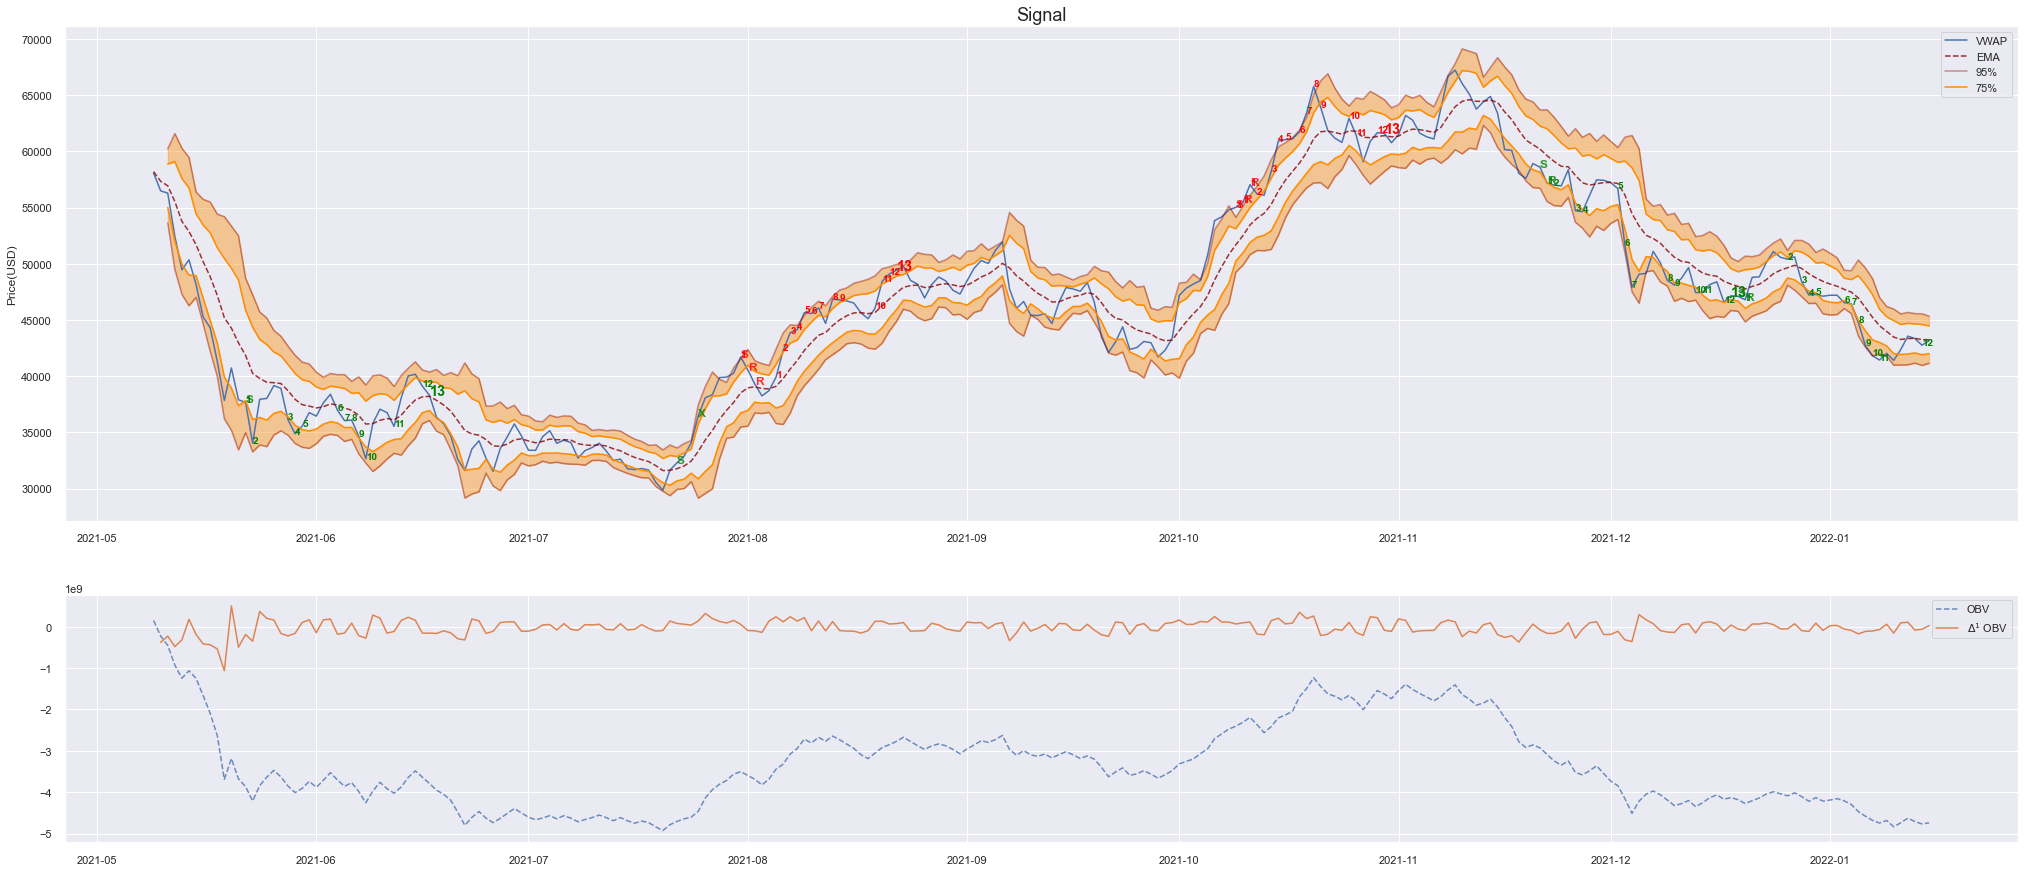

In [151]:
ts = DeMarkBasedTS(days=252)
ts.plot()

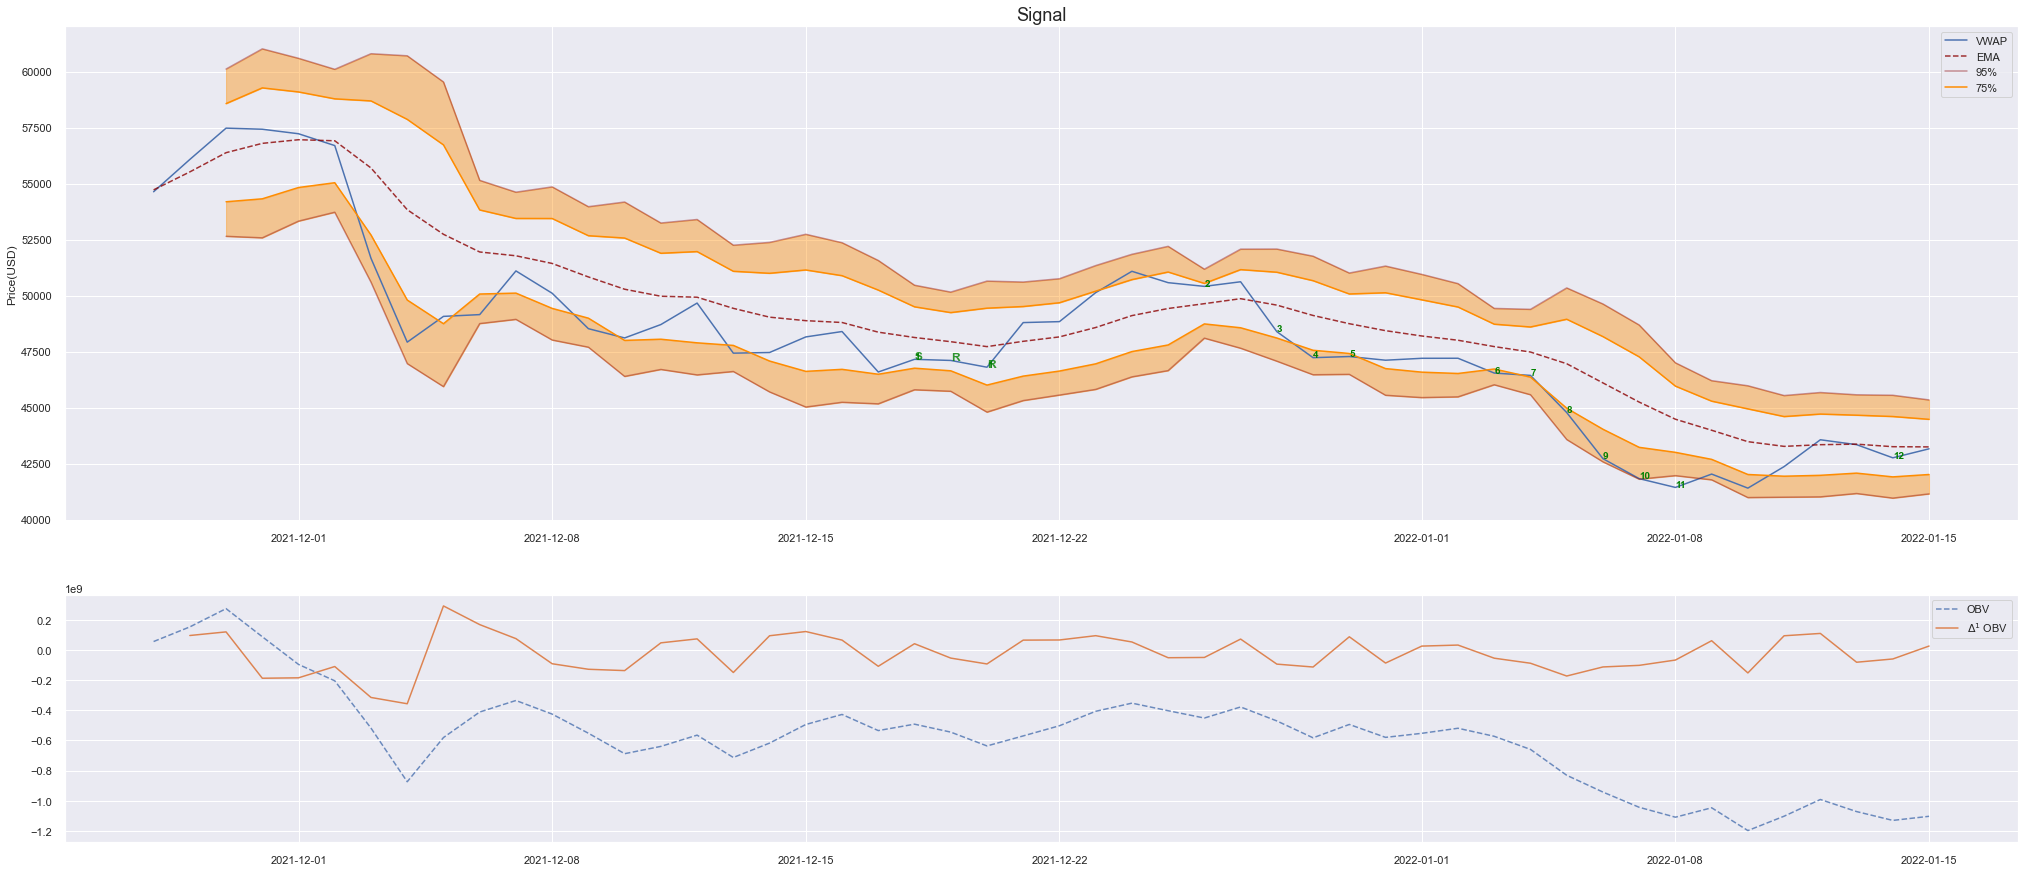

In [152]:
ts = DeMarkBasedTS(days=50)
ts.plot()

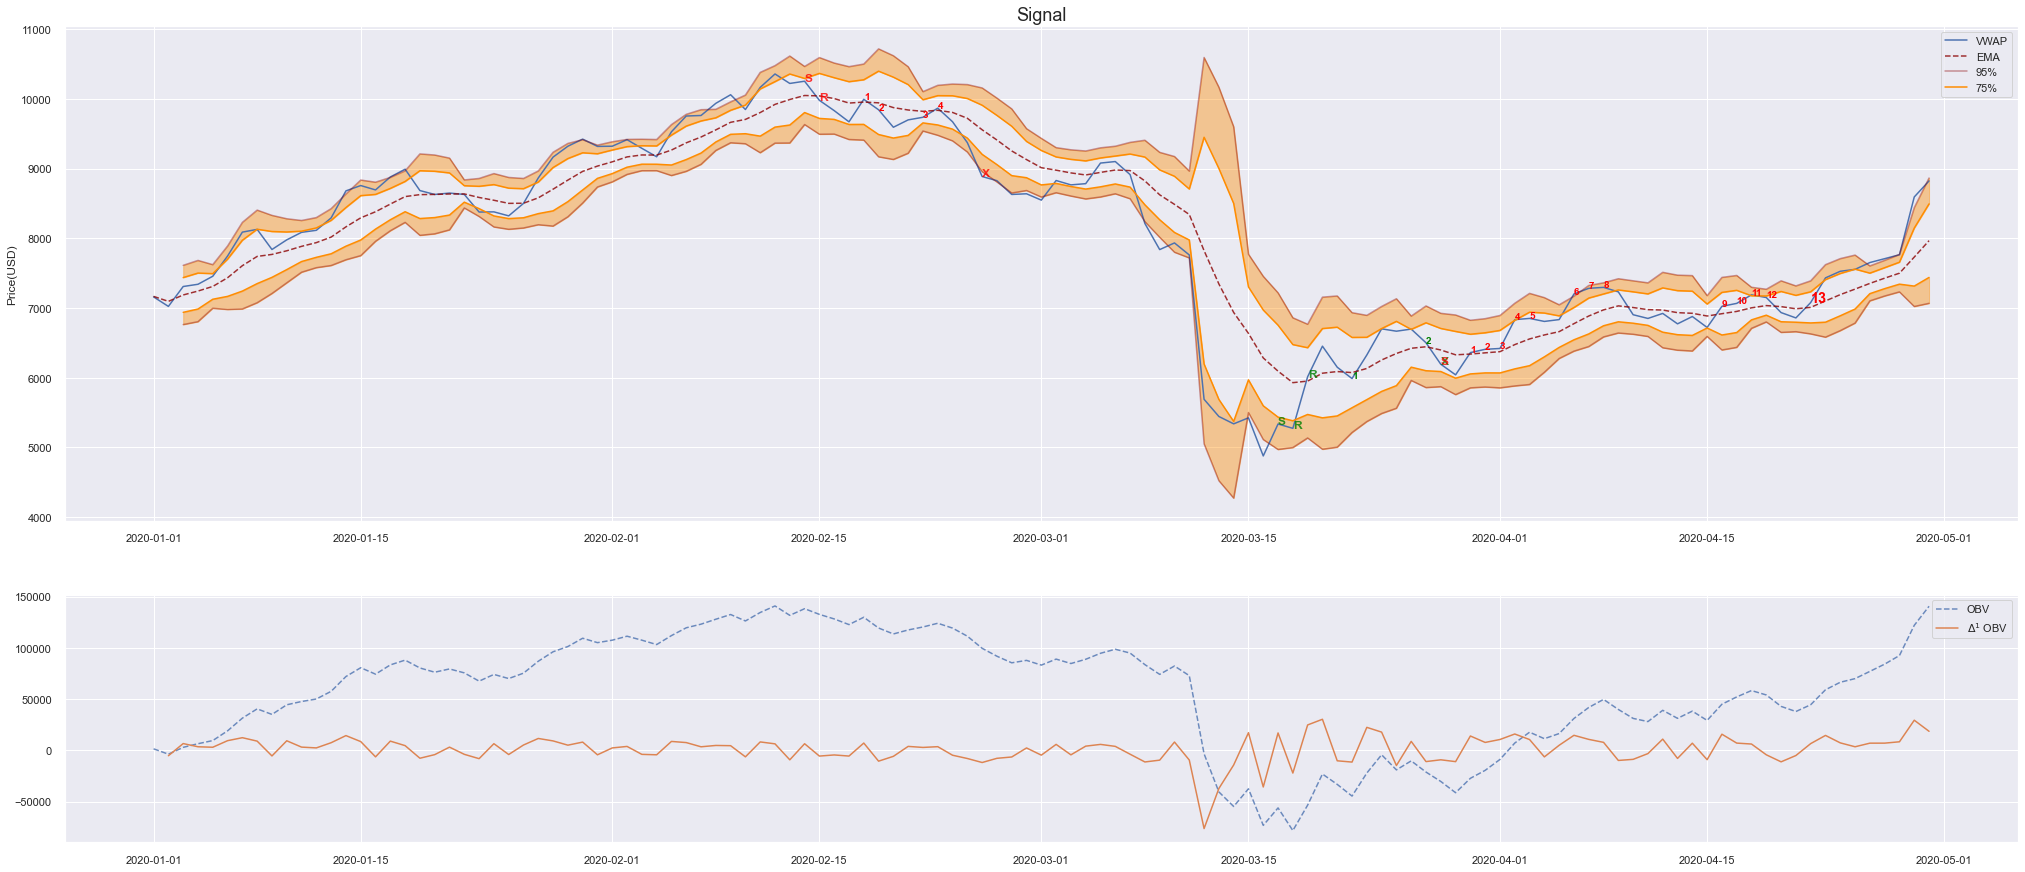

In [153]:
ts = DeMarkBasedTS(start="2020", end="2020-04")
ts.plot()

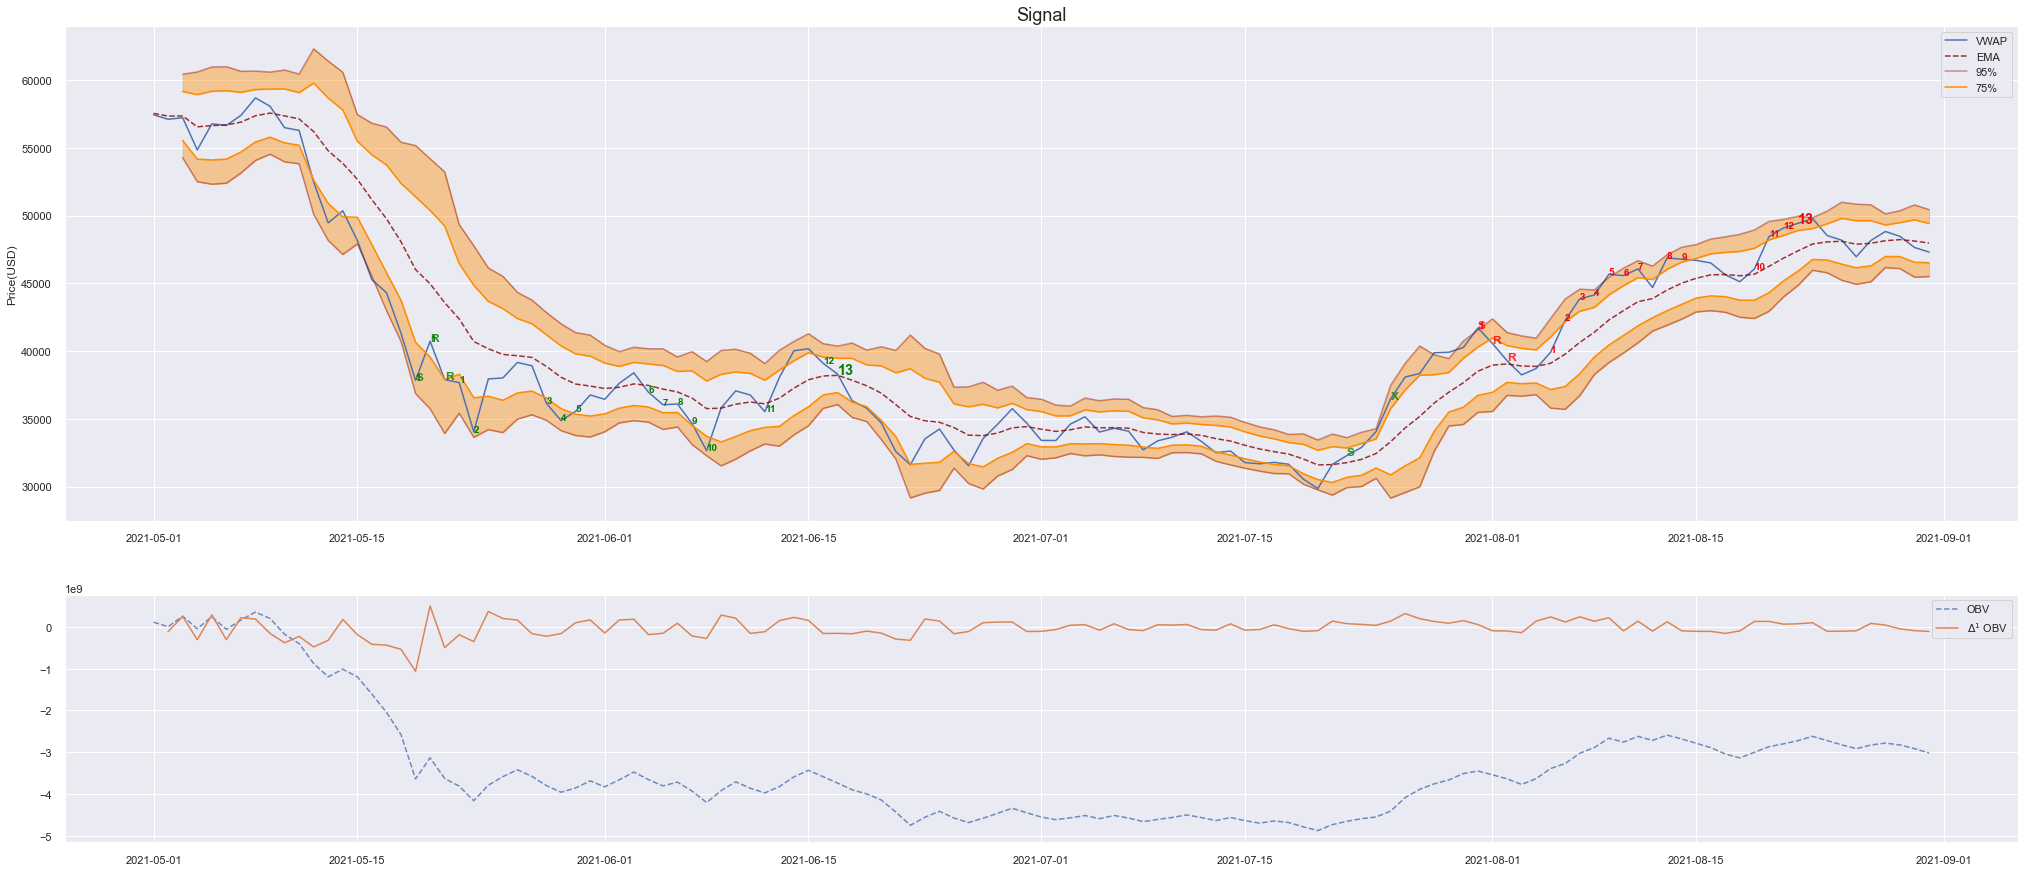

In [154]:
ts = DeMarkBasedTS(start="2021-5", end="2021-8")
ts.plot()